In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.axes_grid1 import host_subplot
from matplotlib.pyplot import figure
from pylab import rcParams

In [3]:
frac = 48 # partes en que se divide un día en el modelo

## Parámetros de fitoplancton "Algas verdes"o "Clorofíceas"

In [4]:
cloroficeas={
"alpha_max" : 1.75, #1/día
"k_r" : 0.3, #1/día
"theta" : 1.07, 
"k" : 4.962,
"a" : 31.957,
"b" : 0.018,
"I_k" : 60, # W/m^2
"k_N" : 0.0115, # mg/l
}

## Parte A

In [5]:
def runge_kutta_4(f,y0,t,chla=False):
    '''Approximate the solution of y'=f(y,t) by Runge Kutta 4 order method.

    Parameters
    ----------
    f : function
        Right-hand side of the differential equation y'=f(t,y), y(t_0)=y_0
    y0 : number
        Initial value y(t0)=y0 where t0 is the entry at index 0 in the array t
    t : array
        1D NumPy array of t values where we approximate y values. Time step
        at each iteration is given by t[n+1] - t[n].

    Returns
    -------
    y : 1D NumPy array
        Approximation y[n] of the solution y(t_n) computed by Runge Kutta 4 order method.
    '''
    y = np.zeros(len(t))
    y[0] = y0
    chla_min = 10**(-6)
    
    for n in range(0,len(t)-1):
        
        h = t[n+1] - t[n]
        k1 = f(y[n], t[n])
        k2 = f(y[n] + 1/2*h*k1, t[n] + 1/2*h)
        k3 = f(y[n] + 1/2*h*k2, t[n] + 1/2*h)
        k4 = f(y[n] + k3*h, t[n] + h)
        y_prox = y[n] + 1/6*(k1 + 2*k2 + 2*k3 + k4)*h
        
        if chla == True and y_prox < chla_min:
            y[n+1] = chla_min
        else:
            y[n+1] = y_prox
            
    return y

In [6]:
def I(t):
    return 150 + 100*np.cos(2*np.pi/365*(t + 11))

In [7]:
def Td(t):
    return 11 + 4*np.cos(2*np.pi/365*(t - 10))

In [8]:
def Tm(T,t):
    return (T + Td(t))/2

In [9]:
def beta_c(T,t):
    return 0.35 + 0.015*Tm(T,t) + 0.0012*(Tm(T,t))**2

In [10]:
def f_uw(uw):
    return 9.2 + 0.46*uw**2

In [11]:
def Ce(T,t,uw=4.8):
    return 4.5 + 0.05*T + (beta_c(T,t) + 0.47)*f_uw(uw)

In [12]:
def Te(T,t):
    return Td(t) + I(t)/Ce(T,t)

In [13]:
def Hn(T,t):
    return Ce(T,t)*(Te(T,t) - T)

In [14]:
Cp = 4181.3 # calor específico del agua (J/°C/kg)
rho_w = 1000 # densidad del agua (kg/m^3)
D = 10 # profundidad del lago (m)
t = np.arange(1,366*frac)/frac
f1 = lambda T,t: Hn(T,t)*60*60*24/(Cp*rho_w*D)
T0 = 18 # temperatura inicial (°C)
T_anual = runge_kutta_4(f1,T0,t)

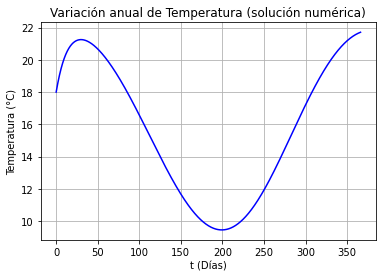

In [15]:
plt.plot(t,T_anual,'b-')
plt.grid(True)
plt.title("Variación anual de Temperatura (solución numérica)")
plt.xlabel("t (Días)")
plt.ylabel("Temperatura (°C)")
rcParams["figure.figsize"] = (6,4)
plt.savefig('fig_t_1.png',dpi=300)
plt.show()

In [16]:
t = np.arange(1,365*frac*10+1)/frac
f1 = lambda T,t: Hn(T,t)*60*60*24/(Cp*rho_w*D)
T0 = 18 # temperatura inicial (°C)
T_anual = runge_kutta_4(f1,T0,t)

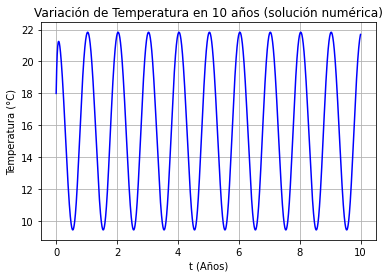

In [17]:
plt.plot(t/365,T_anual,'b-')
plt.grid(True)
plt.title("Variación de Temperatura en 10 años (solución numérica)")
plt.xlabel("t (Años)")
plt.ylabel("Temperatura (°C)")
rcParams["figure.figsize"] = (8,4)
plt.savefig('fig_t_10.png',dpi=300)
plt.show()

## Parte B

In [18]:
def f_T(T, fitopl=cloroficeas):
    theta,k,a,b = list( map(fitopl.get, ['theta','k','a','b']) )
    return theta**(T - 20) - theta**(k*(T - a)) + b

In [19]:
def f_I(t, fitopl=cloroficeas):
    I_k = fitopl['I_k']
    return 1 - np.exp(-I(t)/I_k)

In [20]:
#y=f_N(t, 0, chla_0, 0.1, fitopl=cloroficeas)
#chla=(-I(t)+250)/500+1.8
#y=N(t, 0.05, chla, 0.1)
#plt.plot(t, y,'b.-')


In [21]:
def N(t, dN, chla, N_0, k_chla=0.05):
    N = N_0 + dN * np.cos(2*np.pi/365*(t+30)) - k_chla * chla
    if N<0:
        return 0
    else:
        return N

In [22]:
def f_N(t, dN, chla, N_0, fitopl=cloroficeas):
    k_N = fitopl['k_N']
    N_valor = N(t, dN, chla, N_0)
    N_list.append(N_valor)
    return N_valor/(N_valor + k_N)

In [23]:
def alpha(T, t, dN, chla, N_0, fitopl=cloroficeas):
    alpha_max = fitopl['alpha_max']
    return alpha_max * min(f_I(t) , f_N(t, dN, chla, N_0)) * f_T(T)

In [24]:
def beta(T, fitopl=cloroficeas):
    k_r = fitopl['k_r']
    return k_r * f_T(T)

In [25]:
# Lado derecho de EDO para ChlA
def f2(chla,t):
    año = 365
    if t<2*año+1:
        dN0 = 0
    elif t<6*año+1:
        dN0 = 0.05
    else:
        dN0 = 0.45
    i=int(t*frac)
    if t*frac % i == 0.0:
        return (alpha(T_anual[i-1], t, dN, chla, N_0+dN0) - beta(T_anual[i-1]))*chla
    else:
        T_interpol = (T_anual[i-1] + T_anual[i])/2
        return (alpha(T_interpol, t, dN, chla, N_0+dN0) - beta(T_interpol))*chla

In [96]:
# Cálculo de ChlA y N para dN entre 0.01 y 0.08
N_0_arr = np.array([0.1,0.2,0.3,0.4,0.5])

t = np.arange(1,365*10*frac+1)/frac
lines = np.zeros((5,8,len(t),2))
N_arr = np.zeros((5,8,len(t),2))
T_anual = runge_kutta_4(f1,T0,t)
chla_0 = 10**(-6)
t_años = t/365

for j in range(5):
    N_0 = N_0_arr[j]
    for i in range(8):
        dN = 0.01*(i+1)
        N_list = []
        lines[j,i] = np.column_stack((t_años,runge_kutta_4(f2, chla_0, t, chla=True)))
        k = np.zeros(len(t))
        for m in range(len(N_list)):
            if m%4 == 0:
                k[int(m/4)] = 1/6*(N_list[m] + 2*N_list[m+1] + 2*N_list[m+2] + N_list[m+3])
        N_arr[j,i] = np.column_stack((t_años,k))
        N_arr[j,i,-1,1] = N_arr[j,i,-2,1]
        print(f'Proceso: {j*20+(i+1)*20/8}%')
print('Listo!')

Proceso: 2.5%
Proceso: 5.0%
Proceso: 7.5%
Proceso: 10.0%
Proceso: 12.5%
Proceso: 15.0%
Proceso: 17.5%
Proceso: 20.0%
Proceso: 22.5%
Proceso: 25.0%
Proceso: 27.5%
Proceso: 30.0%
Proceso: 32.5%
Proceso: 35.0%
Proceso: 37.5%
Proceso: 40.0%
Proceso: 42.5%
Proceso: 45.0%
Proceso: 47.5%
Proceso: 50.0%
Proceso: 52.5%
Proceso: 55.0%
Proceso: 57.5%
Proceso: 60.0%
Proceso: 62.5%
Proceso: 65.0%
Proceso: 67.5%
Proceso: 70.0%
Proceso: 72.5%
Proceso: 75.0%
Proceso: 77.5%
Proceso: 80.0%
Proceso: 82.5%
Proceso: 85.0%
Proceso: 87.5%
Proceso: 90.0%
Proceso: 92.5%
Proceso: 95.0%
Proceso: 97.5%
Proceso: 100.0%
Listo!


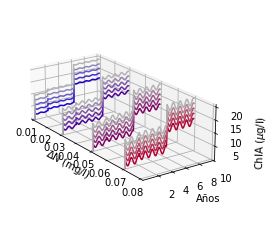

In [27]:
# Gráfico 3D de ChlA para dN entre 0.01 y 0.08
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for j in range(0,8,2):
    r_j = (j+1)/10
    g_j = 0
    b_j = (0.8-j/10)
    for i in range(5):
        mx = 0.7
        r_i = r_j+(mx-r_j)/4*i
        b_i = b_j+(mx-b_j)/4*i
        g_i = mx*i/4
        ax.plot(lines[0,0,:,0],lines[i,j,:,1], zs=(j+1)*0.01, zdir='x', c=(r_i,g_i,b_i))


ax.set_ylim3d(t_años.min(), t_años.max())
ax.set_ylabel('Años')
ax.set_xlim3d(0.01, 0.08)
ax.set_xlabel('$\Delta$N (mg/l)')
ax.set_zlim3d(lines[i,:,:,1].min(), lines[i,:,:,1].max())
ax.set_zlabel('ChlA ($\mu$g/l)')
ax.set_box_aspect(aspect = (7,3,2))
ax.view_init(elev=20., azim=-35)
rcParams["figure.figsize"] = (10,15)

fig.savefig('fig1.png',dpi=200)
plt.show()

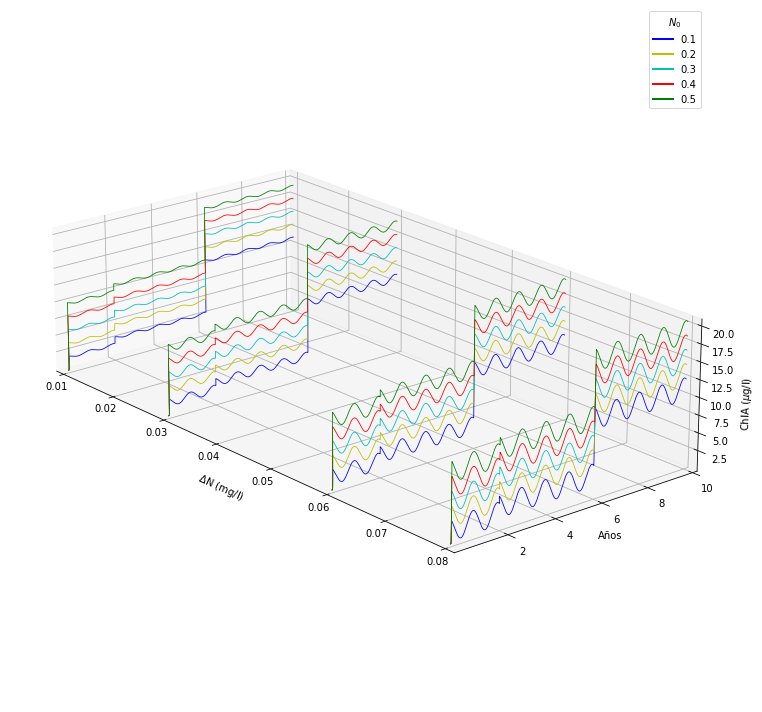

In [28]:
# Gráfico 3D de ChlA para dN entre 0.01 y 0.08
from matplotlib.lines import Line2D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for j in [0,2,5,7]:
    for i in range(5):
        colores = ['b','y','c','r','g']
        ax.plot(lines[0,0,:,0],lines[i,j,:,1], zs=(j+1)*0.01, zdir='x', color = colores[i], linewidth=0.8)

custom_lines = [Line2D([0], [0], color='b', lw=2),
                Line2D([0], [0], color='y', lw=2),
                Line2D([0], [0], color='c', lw=2),
                Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='g', lw=2)]
ax.legend(custom_lines, ['0.1','0.2','0.3','0.4','0.5'], title='$N_0$')
ax.set_ylim3d(t_años.min(), t_años.max())
ax.set_ylabel('Años')
ax.set_xlim3d(0.01, 0.08)
ax.set_xlabel('\n $\Delta$N (mg/l)', linespacing=3.2)
ax.set_zlim3d(lines[i,:,:,1].min(), lines[i,:,:,1].max())
ax.set_zlabel('ChlA ($\mu$g/l)')
ax.set_box_aspect(aspect = (4,2,1))
ax.view_init(elev=20, azim=-40)
rcParams["figure.figsize"] = (8,12)
fig.tight_layout()
fig.savefig('fig1.jpg',dpi=300)
plt.show()

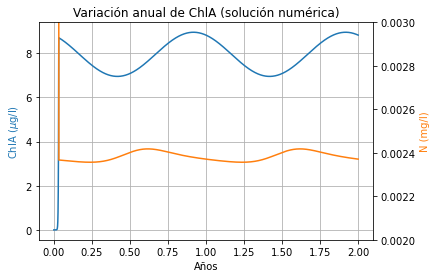

In [43]:
# Gráfico 3D de N para dN entre 0.01 y 0.08
host = host_subplot(111)
par = host.twinx()

host.set_xlabel('Años')
host.set_ylabel('ChlA ($\mu$g/l)')
par.set_ylabel("N (mg/l)")
dN = 0.01

#for i in range(8):
    #colores = ['b','g','r','c','m']
p1, = host.plot(lines[3,0,:365*2*48,0],lines[3,4,:365*2*48,1])#, color = colores[i])
p2, = par.plot(N_arr[3,0,:365*2*48,0],N_arr[3,4,:365*2*48,1])#, color = colores[i])

#leg = plt.legend()

par.set_ylim(0.002, 0.003)
host.yaxis.get_label().set_color(p1.get_color())
#leg.texts[0].set_color(p1.get_color())

par.yaxis.get_label().set_color(p2.get_color())
#leg.texts[1].set_color(p2.get_color())

plt.grid(True)
plt.title("Variación anual de ChlA (solución numérica)")

rcParams["figure.figsize"] = (6,4)
plt.savefig('Chla_N.png',dpi=200)
plt.show()

#fig.savefig('fig2.png',dpi=200)
#plt.show()

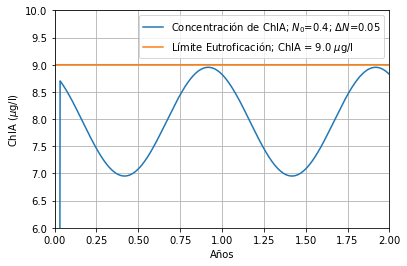

In [78]:
plt.plot(lines[3,0,:365*2*48,0],lines[3,4,:365*2*48,1],label='Concentración de ChlA; $N_0$=0.4; $\Delta N$=0.05')
plt.plot(lines[3,0,:365*2*48,0],np.ones(len(lines[3,0,:365*2*48,0]))*9, label='Límite Eutroficación; ChlA = 9.0 $\mu$g/l')
plt.legend()
plt.xlabel('Años')
plt.ylabel('ChlA ($\mu$g/l)')
plt.grid(True)
plt.xlim(0,2)
plt.ylim(6,10)
plt.savefig('Chla_limite.jpg',dpi=300)
plt.show()

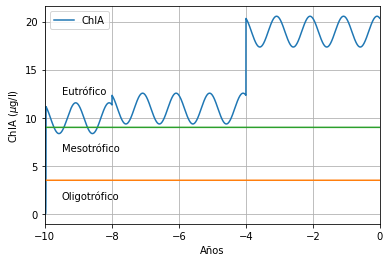

In [77]:
plt.plot(lines[4,7,:,0]-10,lines[4,7,:,1],label='ChlA')
plt.plot(lines[4,7,:,0]-10,np.ones(len(lines[4,7,:,0]))*3.5)
plt.plot(lines[4,7,:,0]-10,np.ones(len(lines[4,7,:,0]))*9)
plt.text(0.5-10,1.5,"Oligotrófico")
plt.text(0.5-10,6.5,"Mesotrófico")
plt.text(0.5-10,12.5,"Eutrófico")
plt.legend()
plt.xlabel('Años')
plt.ylabel('ChlA ($\mu$g/l)')
plt.grid(True)
plt.xlim(-10,0)
#plt.ylim(6,10)
plt.savefig('Chla_trofico.jpg',dpi=300)
plt.show()

In [35]:
# Graficar ChlA versus N
def graf_chla_N(i,j):
    
    host = host_subplot(111)
    par = host.twinx()

    host.set_xlabel('Años')
    host.set_ylabel('ChlA ($\mu$g/l)')
    par.set_ylabel("N (mg/l)")
    
    p1, = host.plot(lines[0,0,:,0],lines[i,j,:,1],'b-', label="ChlA")
    p2, = par.plot(N_arr[0,0,:,0],N_arr[i,j,:,1],'r-', label="N")

    leg = plt.legend()

    host.yaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.yaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())
    
    par.set_ylim(0.002, 0.0029)
    host.set_ylim(8,10)

    plt.grid(True)
    
    a = (i+1)/10 
    b = (j+1)/100
    a_b = str(f'{a}_{b}')
    plt.title("ChlA y Nutrientes Afluentes en 10 años. $N_0$=%s; $\Delta N$=%s" % (a,b))
    plt.tight_layout()
    #plt.savefig('Chla_N_%s.jpg' % a_b ,dpi=300)
    plt.show()

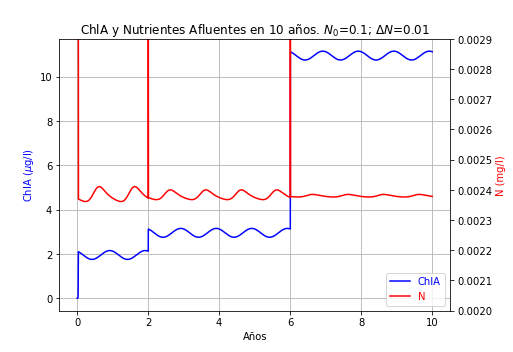

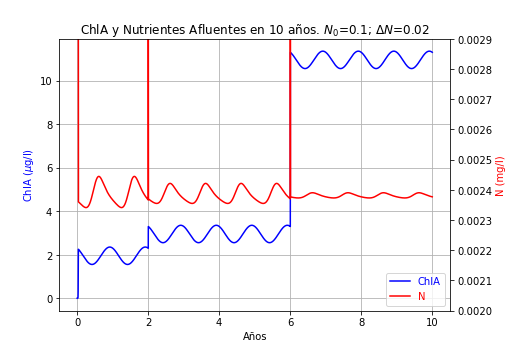

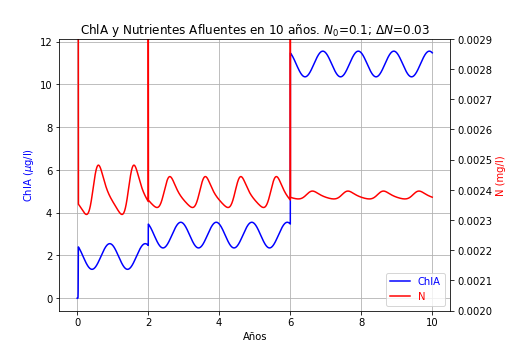

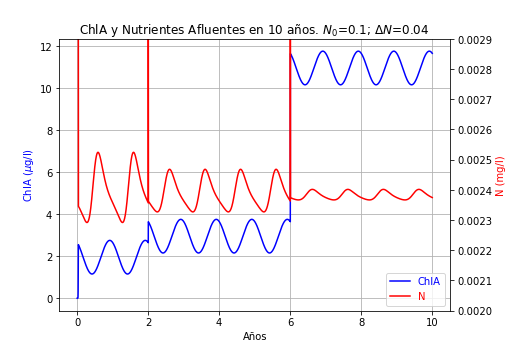

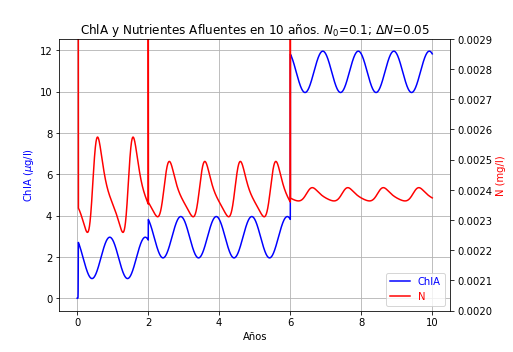

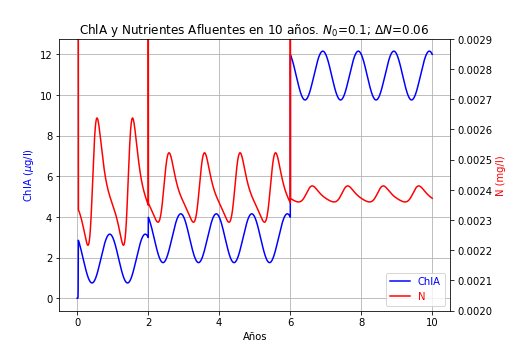

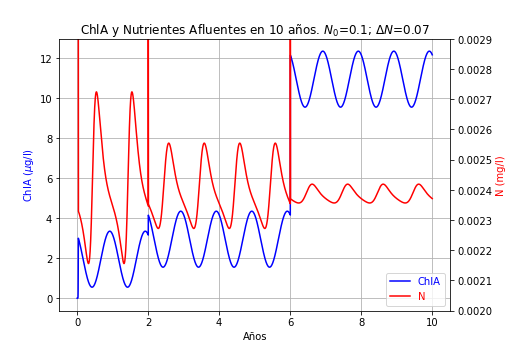

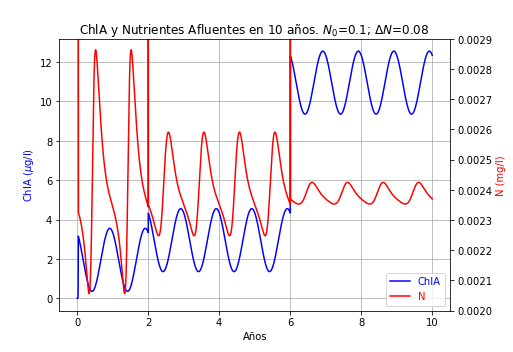

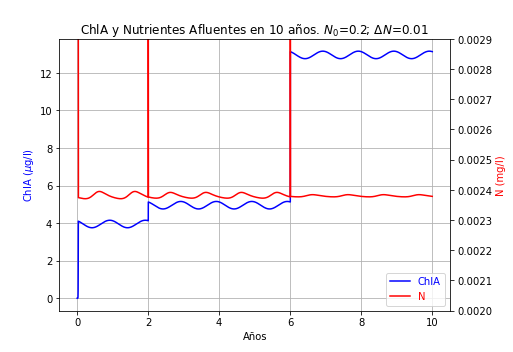

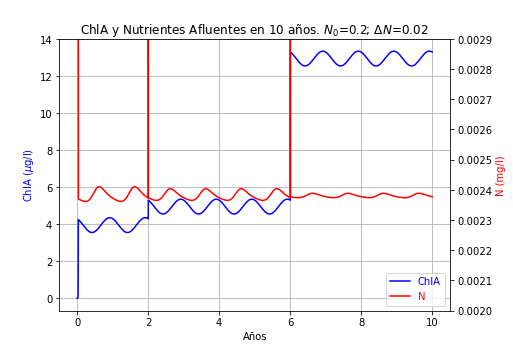

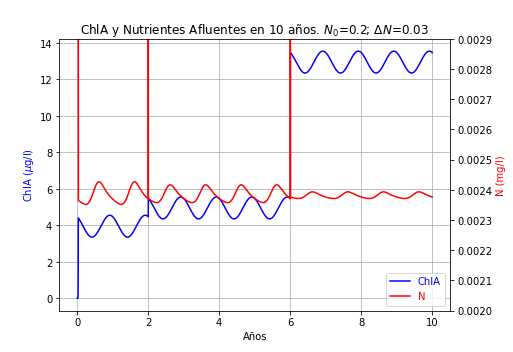

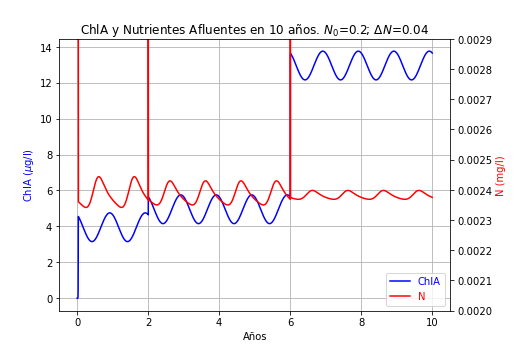

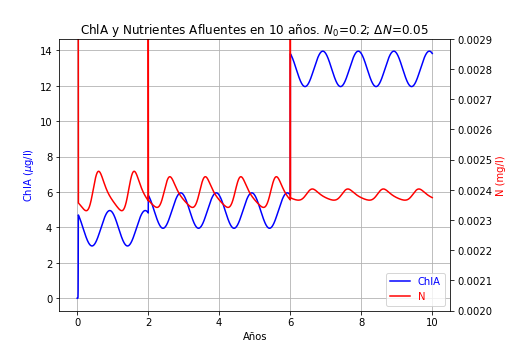

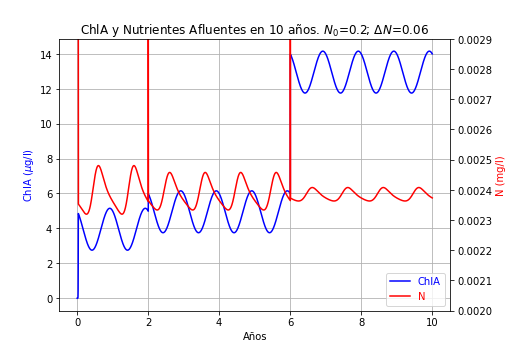

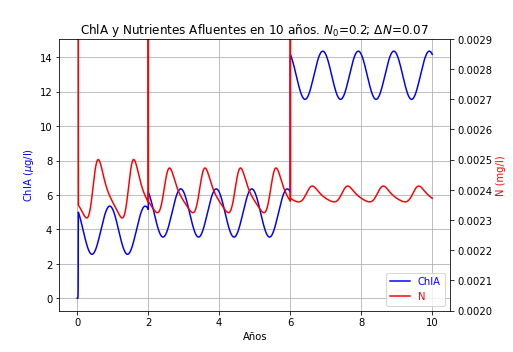

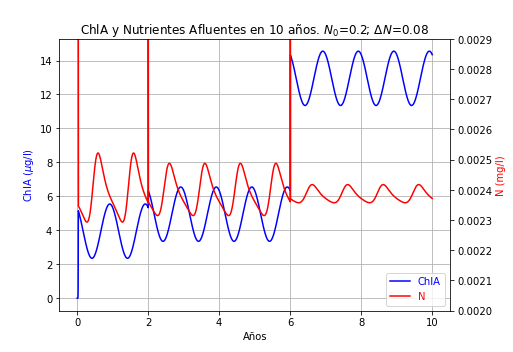

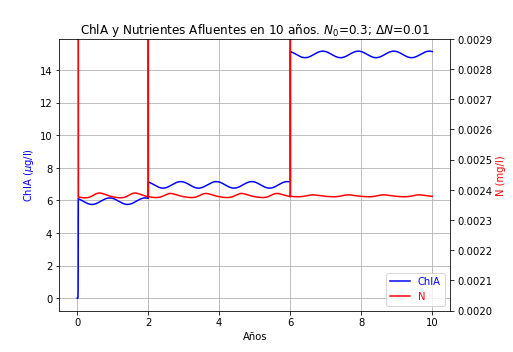

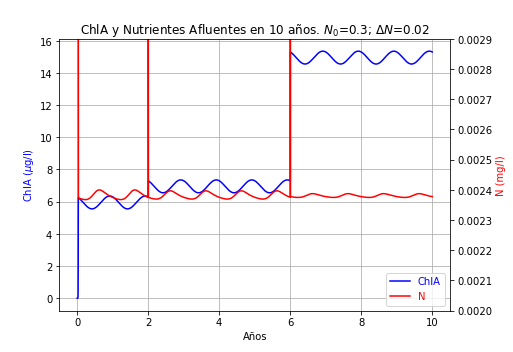

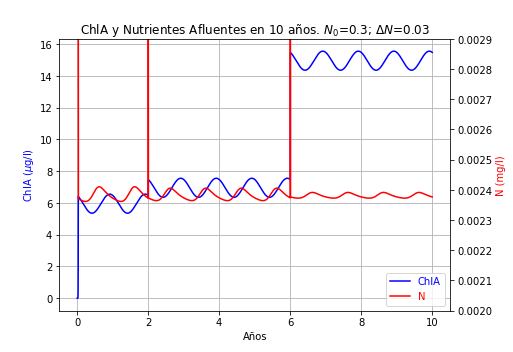

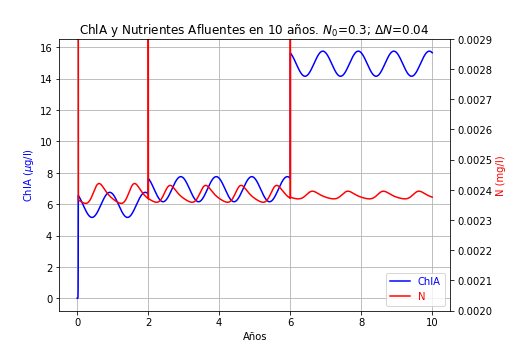

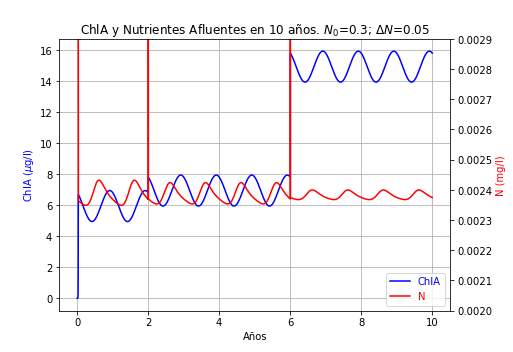

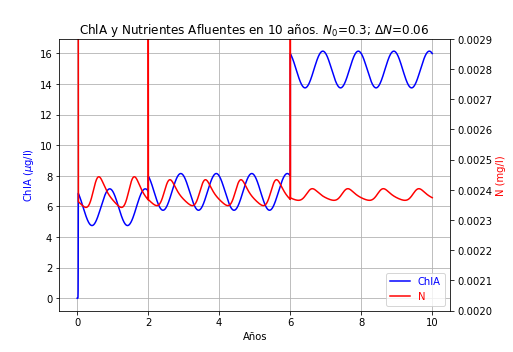

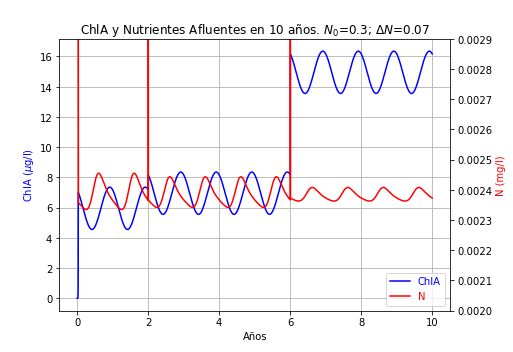

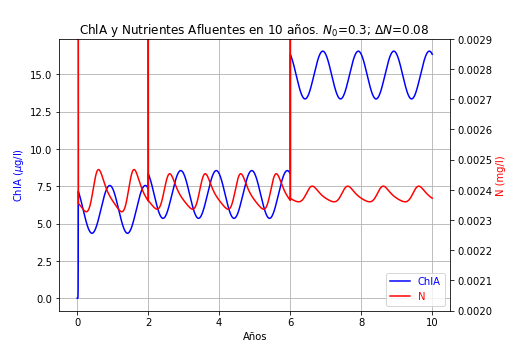

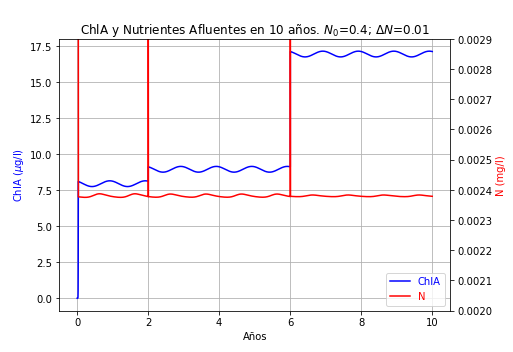

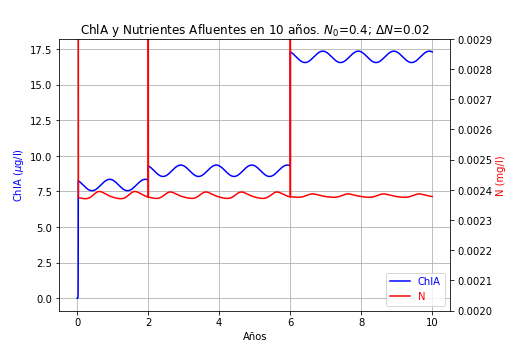

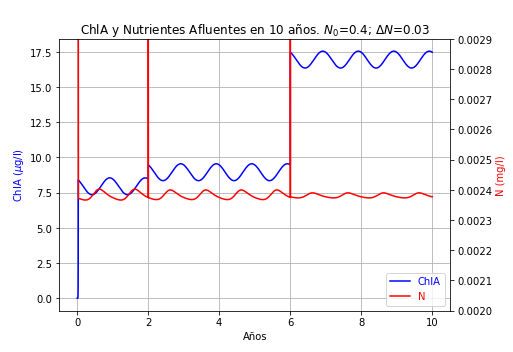

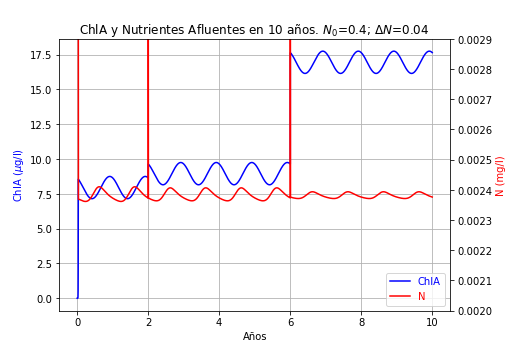

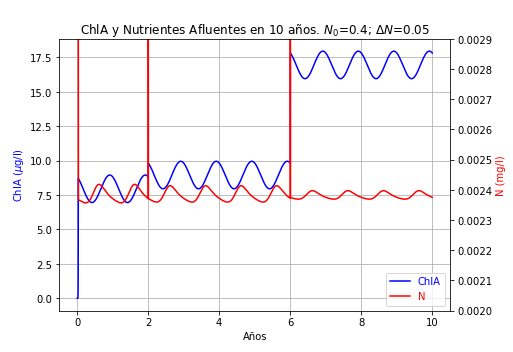

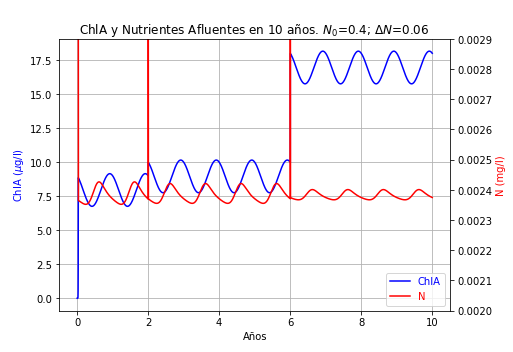

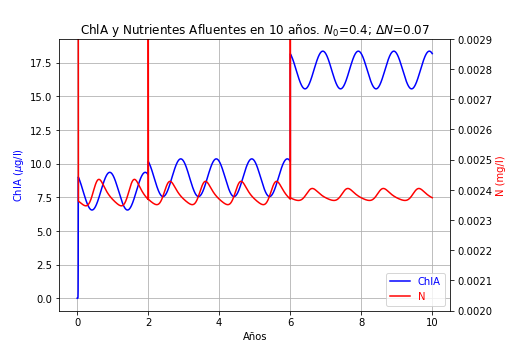

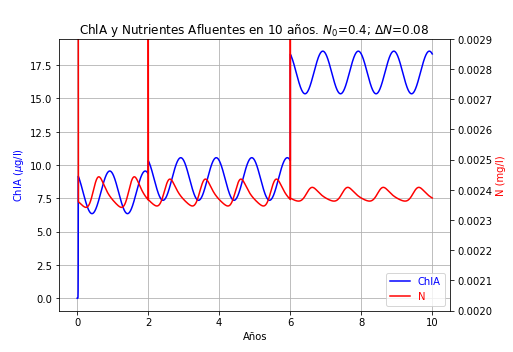

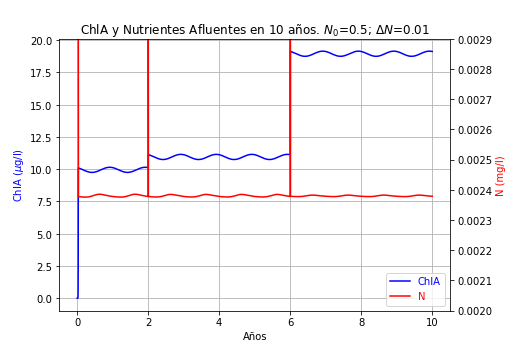

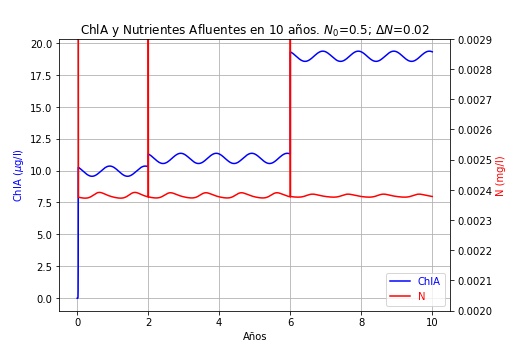

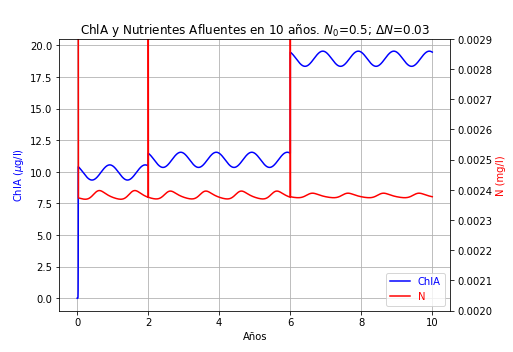

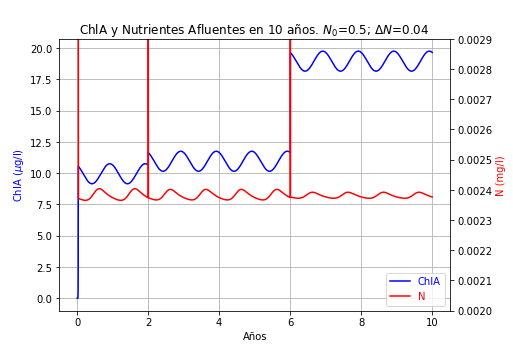

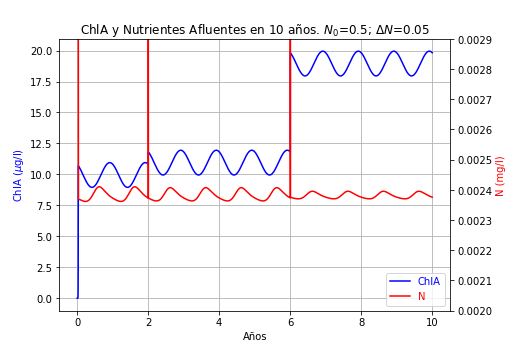

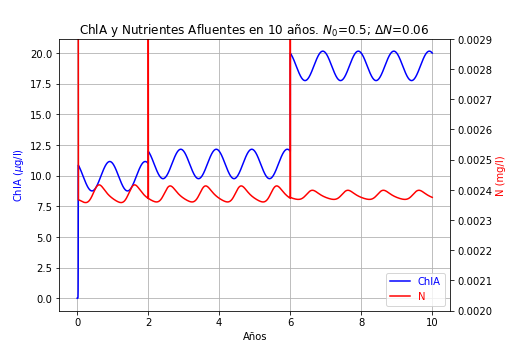

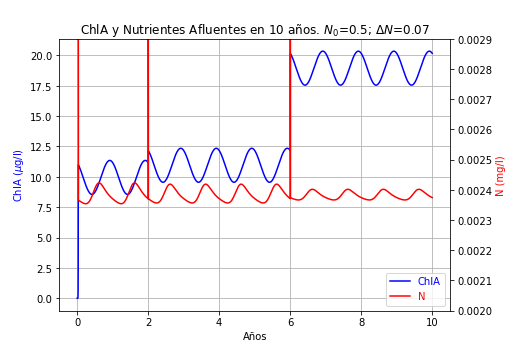

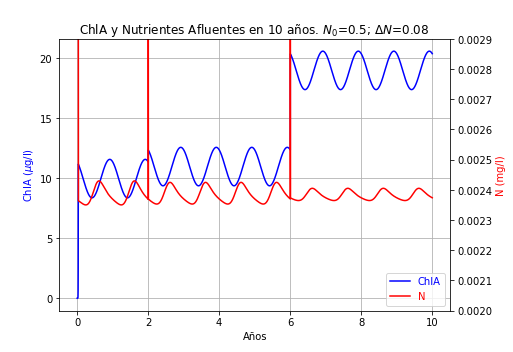

In [32]:
rcParams["figure.figsize"] = (7,5)
for i in range(5):
    for j in range(8):
        graf_chla_N(i,j)

## Parte C

In [117]:
# Lado derecho de EDO para ChlA
def f2_fut(chla,t):
    dN0=0.0
    i=int(t*frac)
    if t*frac % i == 0.0:
        return (alpha(T_anual[i-1], t, dN, chla, N_0+dN0) - beta(T_anual[i-1]))*chla
    else:
        T_interpol = (T_anual[i-1] + T_anual[i])/2
        return (alpha(T_interpol, t, dN, chla, N_0+dN0) - beta(T_interpol))*chla

In [123]:
# Cálculo de ChlA y N para dN entre 0.01 y 0.08
N_0_arr1 = np.array([0.95,0.95*4/5,0.95*3/5,0.95*2/5,0.95*1/5])

t = np.arange(1,365*5*frac+1)/frac
lines1 = np.zeros((5,len(t),2))
T_anual = runge_kutta_4(f1,T0,t)
chla_0 = 10**(-6)
t_años = t/365

for j in range(5):
    N_0 = N_0_arr1[j]
    dN = 0.08
    lines1[j] = np.column_stack((t_años,runge_kutta_4(f2_fut, chla_0, t, chla=True)))
    print(f'Proceso: {(j+1)*20}%')
print('Listo!')

Proceso: 20%
Proceso: 40%
Proceso: 60%
Proceso: 80%
Proceso: 100%
Listo!


In [87]:
t_años.shape

(87600,)

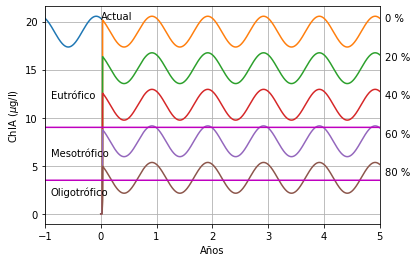

In [130]:
plt.plot(lines[4,7,365*9*48:,0]-10,lines[4,7,365*9*48:,1],label='ChlA')
for i in range(5):
    plt.plot(lines1[i,:,0],lines1[i,:,1])
plt.text(5.1,20,"0 %")
plt.text(0,20.3,"Actual")
plt.text(5.1,16,"20 %")
plt.text(5.1,12,"40 %")
plt.text(5.1,8,"60 %")
plt.text(5.1,4,"80 %")
plt.xlim(-1,5)
#plt.ylim(8,21)

plt.text(-0.9,12,"Eutrófico")
plt.text(-0.9,6,"Mesotrófico")
plt.text(-0.9,2,"Oligotrófico")
plt.plot(lines[4,7,:,0]-1,np.ones(len(lines[4,7,:,0]))*9, c='m')
plt.plot(lines[4,7,:,0]-1,np.ones(len(lines[4,7,:,0]))*3.5, c='m')
plt.xlabel('Años')
plt.ylabel('ChlA ($\mu$g/l)')
plt.grid(True)
#rcParams["figure.figsize"] = (6,4)
plt.savefig('Chla_futuro.jpg',dpi=300)
plt.show()